In [18]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import BaseCrossValidator, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_absolute_error,
    r2_score,
    mean_squared_error,
    root_mean_squared_error
)

import warnings
warnings.filterwarnings('ignore')


In [19]:
sys.path.append(str(Path(__name__).resolve().parents[1]))

from preprocess.src import convert_data as cvd
from train.src import transform as tr

In [20]:
plt.style.use("dark_background")

In [21]:
def RMSE(y_test, y_pred):
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    return rmse


def nMAE(true, pred, nominal):
    absolute_error = np.abs(true - pred)

    absolute_error /= nominal

    target_idx = np.where(true >= nominal*0.1)
    
    return 100 * absolute_error.to_numpy()[target_idx].mean()

def add_lag(df:pd.DataFrame, target:str) -> pd.DataFrame:
    target_map = df[target].to_dict()

    # df['lag1'] = (df.index - pd.Timedelta('1 hours')).map(target_map)
    # df['lag2'] = (df.index - pd.Timedelta('2 hours')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1 days')).map(target_map)
    df['lag4'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    
    return df


class SolarFeatures:
    TARGET = "energy"
    NUM_FEATURES = [
        "Temperature",
        "Humidity",
        "WindSpeed",
        "WindDirection",
    ]
    CAT_FEATURES = [
        "Cloud",
    ]
    DATE_FEATURES = ["Forecast_time"]
    
    SCALE_FEATURES =[
        "Temperature",
        "Humidity",
        "hour_mean",
        "hour_std",
        "cloud_hour_mean"
    ]



class SolarDataset(object):
    def __init__(self,
                 upstream_directory:str,
                 file_prefix: str,
                 file_name: str,
                 ):
        
        self.upstream_directory = upstream_directory
        self.file_prefix = file_prefix
        self.file_name = file_name
        
    def pandas_reader_dataset(self, target:str, time_column:str | None,) -> tuple[pd.DataFrame, pd.Series]:
        file_paths = str(
            Path() / self.upstream_directory / self.file_prefix / self.file_name
        )
        df = pd.read_csv(file_paths)
        if time_column is not None:
            df_ = self.transform_process(df, time_column, target)
            X = df_.drop(labels=[target], axis=1)
            y = df_[target]
            return X, y
        
        X = df.drop(labels=[target], axis=1)
        y = df[target]
        
        return X, y


    def transform_process(self, df:pd.DataFrame, time_column:str="Forecast_time", target:str="load"):
        tr.set_time_index(df,time_column)
        df = tr.create_time_features(df)
        df = tr.create_time_lag_features(df, target=target)
        df = tr.convert_wind(df=df, speed="WindSpeed", direction="WindDirection")
        df = tr.convert_cloudy(df=df, column="Cloud", Forecast=True)
                
        hour_group_energy = tr.grouped_frame(df=df, group_col_list=['hour'], target_col_list=[target], method='mean')
        hour_group_energy_std = tr.grouped_frame(df=df, group_col_list=['hour'], target_col_list=[target], method='std')
        df['hour_mean'] = df.apply(lambda x: hour_group_energy.loc[(hour_group_energy.hour == x['hour']), f'{target}_mean'].values[0], axis=1)
        df['hour_std'] = df.apply(lambda x: hour_group_energy_std.loc[(hour_group_energy_std.hour == x['hour']), f'{target}_std'].values[0], axis=1)
        cloud_hour_gruop_energy = tr.grouped_frame(df=df, group_col_list=["Cloud", "hour"], target_col_list=[target], method="mean")
        df['cloud_hour_mean'] = df.apply(lambda x: cloud_hour_gruop_energy.loc[(cloud_hour_gruop_energy.hour == x['hour']) & (
            cloud_hour_gruop_energy.Cloud == x['Cloud']), f'{target}_mean'].values[0], axis=1)
        
        df = tr.transform_cyclic(df, col="hour", max_val=23)
        df = tr.transform_cyclic(df, col="month", max_val=12)
        df = tr.transform_cyclic(df, col="dayofweek", max_val=6)
        df = tr.transform_cyclic(df, col="quarter", max_val=4)
        df = tr.transform_cyclic(df, col="dayofyear", max_val=365)

        
        return df

def get_solar_pipeline():
    
    numeric_features = SolarFeatures.SCALE_FEATURES
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
    )

    categorical_features = SolarFeatures.CAT_FEATURES
    categorical_transformer = Pipeline(
        steps=[
            ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )
    return preprocessor 

In [22]:
train_set = SolarDataset(upstream_directory="../data/preprocess/solar/", file_prefix="train", file_name="train_dataset.csv")
test_set = SolarDataset(upstream_directory="../data/preprocess/solar/", file_prefix="test", file_name="test_dataset.csv")

In [23]:
X_train, y_train = train_set.pandas_reader_dataset(target="energy", time_column="Forecast_time")
X_test, y_test = test_set.pandas_reader_dataset(target="energy", time_column="Forecast_time")

In [24]:
X_train.dropna().head()

,Temperature,Humidity,Cloud,dayofmonth,lag_day_1,lag_day_2,wind_x,wind_y,hour_mean,hour_std,...,hour_sin,hour_cos,month_sin,month_cos,dayofweek_sin,dayofweek_cos,quarter_sin,quarter_cos,dayofyear_sin,dayofyear_cos
Forecast_time,,,,,,,,,,,,,,,,,,,,,
2018-03-09 00:00:00,5.000000,75.0,Mostly,9,0.0,0.0,1.836701,-1.018100,0.0,0.0,...,0.000000,1.000000,1.0,6.123234e-17,-0.866025,-0.5,1.0,6.123234e-17,0.920971,0.38963
2018-03-09 01:00:00,4.666667,75.0,Mostly,9,0.0,0.0,2.079015,-1.059311,0.0,0.0,...,0.269797,0.962917,1.0,6.123234e-17,-0.866025,-0.5,1.0,6.123234e-17,0.920971,0.38963
2018-03-09 02:00:00,4.333333,75.0,Mostly,9,0.0,0.0,2.326190,-1.084720,0.0,0.0,...,0.519584,0.854419,1.0,6.123234e-17,-0.866025,-0.5,1.0,6.123234e-17,0.920971,0.38963
2018-03-09 03:00:00,4.000000,75.0,Mostly,9,0.0,0.0,2.577414,-1.094047,0.0,0.0,...,0.730836,0.682553,1.0,6.123234e-17,-0.866025,-0.5,1.0,6.123234e-17,0.920971,0.38963
2018-03-09 04:00:00,3.666667,75.0,Mostly,9,0.0,0.0,2.421847,-0.945862,0.0,0.0,...,0.887885,0.460065,1.0,6.123234e-17,-0.866025,-0.5,1.0,6.123234e-17,0.920971,0.38963


In [7]:
print(f"Shape of X_train {X_train.shape} and y_train {y_train.shape}")
print(f"Shape of X_test {X_test.shape} and y_test {y_test.shape}")

Shape of X_train (24864, 21) and y_train (24864,)
Shape of X_test (744, 21) and y_test (744,)


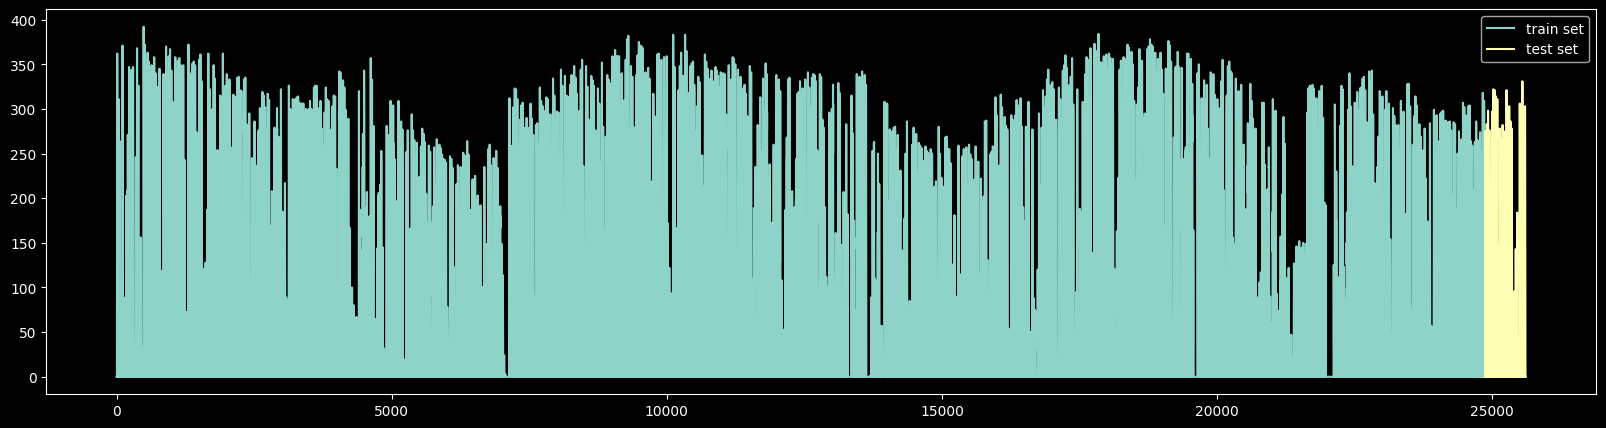

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(20, 5))

train_gen = y_train
test_gen = y_test

indices = list(range(train_gen.shape[0] + test_gen.shape[0]))

axes.plot(indices[:train_gen.shape[0]], train_gen, label="train set")
axes.plot(indices[train_gen.shape[0]:], test_gen, label="test set")
axes.legend()

In [9]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
kf = KFold(n_splits=5, random_state=42, shuffle=True)


In [10]:
models = []
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    model = RandomForestRegressor()
    input_pipeline = get_solar_pipeline()
    model_ = Pipeline([("preprocessor", input_pipeline), ("model", model)]) 
    
    model_.fit(X_train.iloc[train_index], y_train.iloc[train_index])
    models.append(model_)
    y_preds = model_.predict(X_train.iloc[test_index])

    # Evaluate predictions
    mae_score = mean_absolute_error(y_train.values[test_index], y_preds)
    mse_score = mean_squared_error(y_train.values[test_index], y_preds)
    rmse_score = RMSE(y_train.values[test_index], y_preds)
    nmae_score = nMAE(true=y_train[test_index], pred=y_preds, nominal=500)
    # Log model performance metrics to W&B
    print({"rmse": rmse_score, "mae": mae_score, "mse": mse_score, "nmae":nmae_score})

{'rmse': 44.704858643955575, 'mae': 21.793416425421135, 'mse': 1998.5243863760495, 'nmae': 10.250043403555122}
{'rmse': 43.41040776765125, 'mae': 21.033763573213168, 'mse': 1884.463502553756, 'nmae': 9.623128676730353}
{'rmse': 45.74161173713785, 'mae': 22.400546077321398, 'mse': 2092.2950443110676, 'nmae': 10.460283304039743}
{'rmse': 43.465351020755364, 'mae': 21.812136331603913, 'mse': 1889.236739357479, 'nmae': 10.055995101033023}
{'rmse': 45.146351600654974, 'mae': 22.65378131471884, 'mse': 2038.1930628499617, 'nmae': 10.403529919343804}


In [11]:


X_train_ = X_train.dropna()
y_train_ = y_train[X_train_.index]
model = RandomForestRegressor()
input_pipeline = get_solar_pipeline()
model_ = Pipeline([("preprocessor", input_pipeline), ("model", model)]) 
model_.fit(X_train_, y_train_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Temperature', 'Humidity',
                                                   'hour_mean', 'hour_std',
                                                   'cloud_hour_mean']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Cloud'])])),
                ('model', RandomForestRegressor())])

In [12]:
lgb_preds = model_.predict(X_test)

In [13]:
y_preds = []
for model in models:
    y_pred = model.predict(X_test)
    y_preds.append(y_pred)

In [14]:
y_predictions = np.array(y_preds).mean(axis=0)

In [ ]:

# Evaluate predictions
mae_score = mean_absolute_error(y_test, y_predictions)
mse_score = mean_squared_error(y_test, y_predictions)
rmse_score = RMSE(y_test, y_predictions)
nmae_score = nMAE(true=y_test, pred=y_predictions, nominal=500)

# Log model performance metrics to W&B
print({"rmse": rmse_score, "mae": mae_score, "mse": mse_score, "nmae":nmae_score})

{'smape': 33.23967251083732, 'mape': 95.63670608755649, 'rmse': 28.188665095937026, 'mae': 12.80047292181385, 'mse': 794.6008398908984, 'nmae': 7.043332286602287}


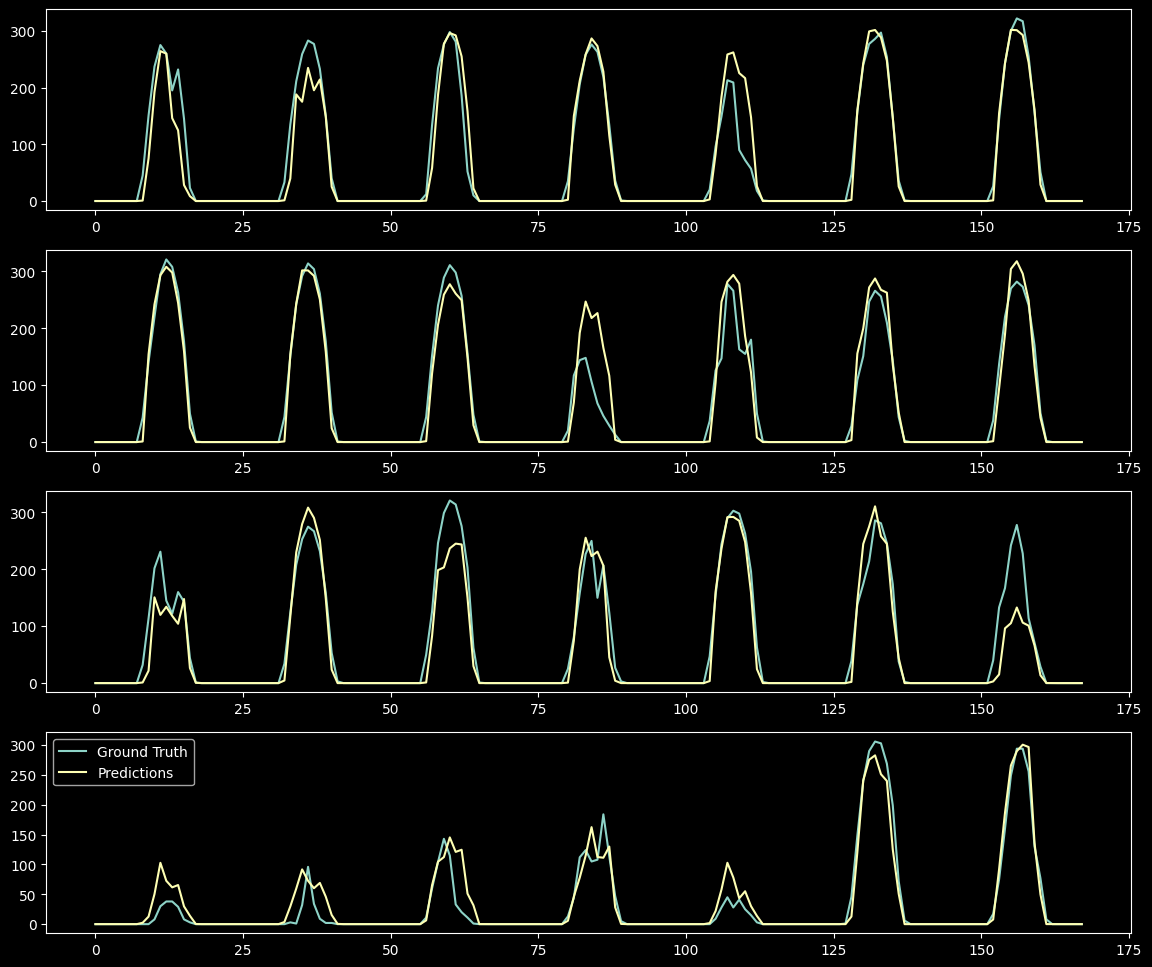

In [17]:
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

step = 168
ax_i = 0
for i in range(0, y_test.shape[0], step):
    if ax_i > 3:
        break
    axes[ax_i].plot(y_test[i:i+step].to_numpy(), label="Ground Truth")
    axes[ax_i].plot(y_predictions[i:i+step], label="Predictions")
    ax_i += 1
plt.legend()

<Axes: >

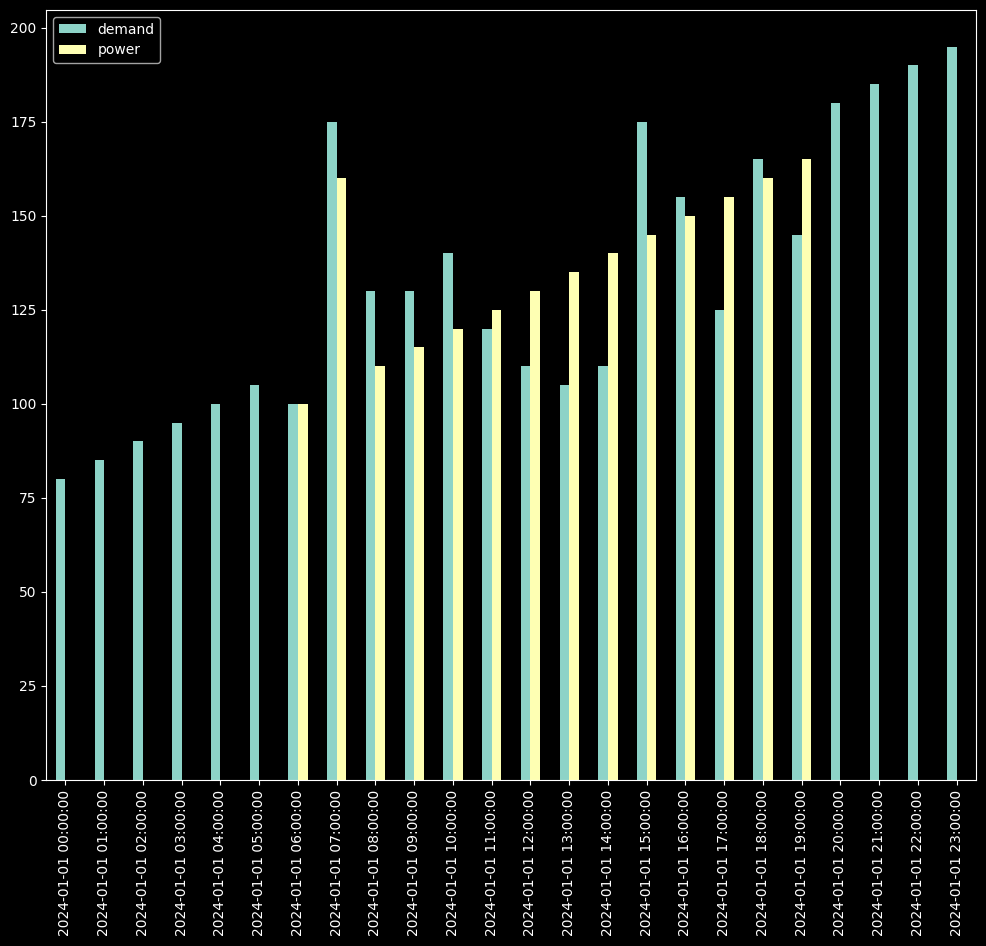

In [26]:
# Sample Data Set
# Assuming the demand and power is forecasted values.
data = pd.DataFrame({"demand": [80, 85, 90, 95, 100, 105, 100, 175, 130, 130, 140, 120, 110, 105, 110, 175, 155, 125, 165, 145, 180, 185, 190, 195],
                     "power": [0, 0, 0, 0, 0, 0, 100, 160, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 0, 0, 0, 0]})
data.index = pd.date_range(start="2024-01-01", periods=len(data), freq="h")
data.head(10)

data.plot.bar(figsize=(12, 10))

<Axes: >

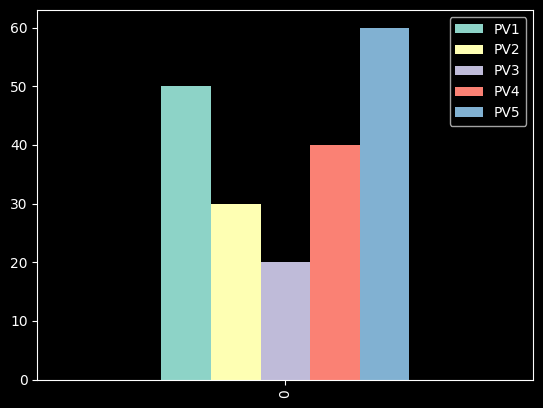

In [27]:
PVs = pd.DataFrame({"PV1": 50, "PV2": 30, "PV3": 20, "PV4": 40, "PV5": 60}, index=[0]) # Values means the rated power of PV.
PVs.plot.bar()